We will benchmark the elastic $(p,p)$, $(n,n)$ and quasi-elastic $(p,n)$ calculations comparing `JITR` to `CHEX`.

TODO:
- define a common $s$-mesh and quadrature for both entrance and exit channels to allow for DWBA

In [1]:
import pickle
from pathlib import Path

import chexpy
import numpy as np
import pandas as pd
import rose
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

import jitr

In [2]:
from matplotlib import colormaps as cm
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator, StrMethodFormatter
from rose.training import multiple_formatter

colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]

plt.rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rcParams[
    "text.latex.preamble"
] = r"\usepackage{amssymb} \usepackage{amsmath} \usepackage{braket}"
plt.rc("text", usetex=True)

rcParams["legend.fontsize"] = 12
rcParams["font.size"] = 14
rcParams["font.weight"] = "normal"
rcParams["xtick.labelsize"] = 12.0
rcParams["ytick.labelsize"] = 12.0
rcParams["lines.linewidth"] = 2.0
rcParams["xtick.major.pad"] = "10"
rcParams["ytick.major.pad"] = "10"
rcParams["image.cmap"] = "BuPu"

In [3]:
print(rose.__version__)

1.1.3.dev6+g772a848


In [4]:
from rose.koning_delaroche import KDGlobal, Projectile

n = Projectile.neutron
p = Projectile.proton

# initial and final systems
# Core p + Ca48
Ca48 = (48, 20)

# n + IAS
Sc48 = (48, 21)

# lab bombarding energy
E_lab = 35  # MeV

# excitation energy to isobaric analog state
E_IAS = 6.67  # MeV

# approximation of -Q - the Coulomb displacement energy
CDE = 1.33 * (Ca48[1] + Sc48[1]) * 0.5 / Ca48[0] ** (1.0 / 3.0)

# excitation energy to isobaric analog state
Q_IAS = (
    rose.utility.get_AME_binding_energy(*Sc48)
    - rose.utility.get_AME_binding_energy(*Ca48)
    - E_IAS
)
print(f"Q = {Q_IAS}, CDE = {CDE}")

# set up global optical model potentials w/ default KD params
omps = {
    n: rose.koning_delaroche.KDGlobal(n),
    p: rose.koning_delaroche.KDGlobal(p),
}

Q = -7.173131200000098, CDE = 7.502253870092668


In [5]:
xsn = pd.read_csv(
    "./chex_benchmark_results/CEResults/OutNucleonElasticCS.txt",
    names=["theta", "dxs", "err"],
    sep="\s+",
)

In [6]:
xsp = pd.read_csv(
    "./chex_benchmark_results/CEResults/InNucleonRatioToRuth.txt",
    names=["theta", "dxs", "err"],
    sep="\s+",
)

In [7]:
xspn = pd.read_csv(
    "./chex_benchmark_results/CEResults/ChargeExchangeCS.txt",
    names=["theta", "dxs", "err"],
    sep="\s+",
)

In [8]:
# set up meshes for visualization
a = 30
angles = np.array(xsn["theta"], dtype=np.float64) * np.pi / 180

In [9]:
interactions = {}
params = {}

In [10]:
# set up p + Ca48 system
# kinematics for p + Ca48 system
mu_p, E_com_p, k_p, eta_p = rose.utility.kinematics(
    target=Ca48, projectile=(1, 1), E_lab=E_lab
)

# get default OMP params for p + Ca48 system
R_C, parameters = omps[p].get_params(*Ca48, mu_p, E_lab, k_p)

params[p] = (R_C, parameters)

# set up interaction space for p + Ca48 system
interactions[p] = rose.InteractionSpace(
    coordinate_space_potential=rose.koning_delaroche.KD_simple,
    n_theta=rose.koning_delaroche.NUM_PARAMS,
    mu=mu_p,
    energy=E_com_p,
    is_complex=True,
    spin_orbit_term=rose.koning_delaroche.KD_simple_so,
    Z_1=1,
    Z_2=Ca48[1],
    R_C=R_C,
    l_max=50,
)

In [11]:
# set up n + Sc48 system
# kinematics for n + Sc48 system
E_com_n = E_com_p + Q_IAS
mu_n, E_lab_n, k_n, eta_n = rose.utility.kinematics(
    target=Sc48, projectile=(1, 0), E_com=E_com_n
)

# get default OMP params for n + Sc48 system
_, parameters = omps[n].get_params(*Sc48, mu_n, E_lab_n, k_n)
params[n] = (R_C, parameters)

# set up interaction space for n + Sc48 system
interactions[n] = rose.InteractionSpace(
    coordinate_space_potential=rose.koning_delaroche.KD_simple,
    n_theta=rose.koning_delaroche.NUM_PARAMS,
    mu=mu_n,
    energy=E_com_n,
    is_complex=True,
    spin_orbit_term=rose.koning_delaroche.KD_simple_so,
    Z_1=0,
    Z_2=Sc48[1],
    l_max=50,
)

In [12]:
s_0_p = a * k_p
s_0_n = a * k_n
min_s = 1e-1
s_mesh_p = np.linspace(min_s, s_0_p, 1000)
domain_p = [min_s, s_0_p]
s_mesh_n = np.linspace(min_s, s_0_n, 1000)
domain_n = [min_s, s_0_n]

In [13]:
N = 100
solver = jitr.RMatrixSolver(N)

In [14]:
# set up solvers
solvers = {}

solvers[n] = rose.ScatteringAmplitudeEmulator.HIFI_solver(
    interactions[n],
    base_solver=rose.LagrangeRmatrix(
        interactions[n].interactions[0][0],
        s_0_n,
        solver,
    ),
    angles=angles,
    s_mesh=s_mesh_n,
)

solvers[p] = rose.ScatteringAmplitudeEmulator.HIFI_solver(
    interactions[p],
    base_solver=rose.LagrangeRmatrix(
        interactions[p].interactions[0][0],
        s_0_p,
        solver,
    ),
    angles=angles,
    s_mesh=s_mesh_p,
)

Let's compare the value of the isovector component of the optical potential the `JITR` solver and the original `CHEX` solver, for a single partial wave.

In [15]:
params[p][1]

array([47.13547773,  4.33328708,  0.6706624 ,  3.53838802,  4.33328708,
        0.6706624 ,  6.85454469,  4.66926318,  0.543684  ,  5.11263624,
        3.6610295 ,  0.59      , -0.2065247 ,  3.6610295 ,  0.59      ])

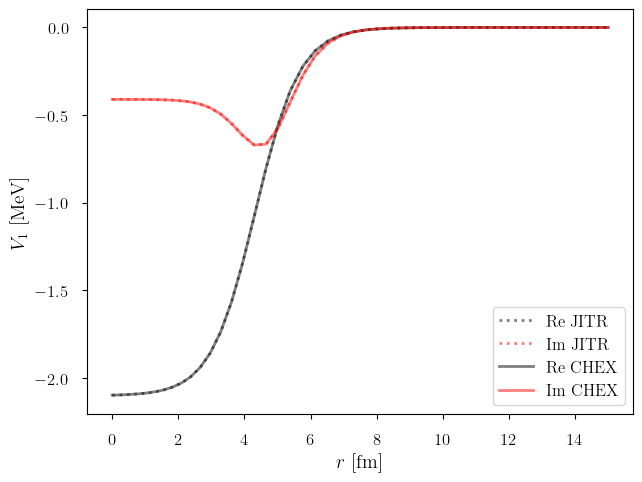

In [16]:
import pandas as pd

chex_v1 = pd.read_csv(
    "./chex_benchmark_results/CEResults/KD_pot.txt",
    names=["r", "V", "W"],
    sep="\s+",
)

# CHEX uses Ecm to evaluate V1, not Elab. Elab is used for distorted waves
# CHEX also includes the full Coulomb potential in V1

# to do apples to apples, lets get new params with Ecm and calculate V1 in the same way as CHEX
_, alphan = omps[n].get_params(*Sc48, mu_n, E_com_n, k_n)
RC, alphap = omps[p].get_params(*Ca48, mu_p, E_com_p, k_p)


def jitr_v1(r, li, ji, alphan, alphap):
    A, Z = Ca48
    N = A - Z
    vn = interactions[n].interactions[li][ji].v_r(r, alphan) + interactions[
        n
    ].interactions[li][ji].spin_orbit_term.spin_orbit_potential(r, alphan)
    vp = interactions[p].interactions[li][ji].v_r(r, alphap) + interactions[
        p
    ].interactions[li][ji].spin_orbit_term.spin_orbit_potential(r, alphap)
    v1 = -(vn - vp) * np.sqrt(np.fabs(N - Z)) / (N - Z - 1)
    return v1


r = np.array(chex_v1["r"])
jitrv1 = jitr_v1(r, 0, 0, alphan, alphap)
plt.plot(r, jitrv1.real, ":k", label="Re JITR", alpha=0.5)
plt.plot(r, jitrv1.imag, ":r", label="Im JITR", alpha=0.5)

plt.plot(chex_v1["r"], chex_v1["V"], "k", label="Re CHEX", alpha=0.5)
plt.plot(chex_v1["r"], chex_v1["W"], "r", label="Im CHEX", alpha=0.5)

plt.legend()
plt.tight_layout()
plt.xlabel(r"$r$ [fm]")
plt.ylabel(r"$V_1$ [MeV]")
plt.show()

Let's compare phase shifts and partial waves between the `JITR` solver and the original `CHEX` solver, for a single partial wave.

Let's compare the elastic cross sections for the entrance and exit channels between the `JITR` solver and the original `CHEX` solver, for a single partial wave.

First, for comparison, let's duplicate the same solvers and interactions, but using the same reduced mass as CHEX, which is just calculated like $A/(A+1)m_n$. This will tell us about how important our relativistic correction is.

In [17]:
interactions_kip = rose.InteractionSpace(
    coordinate_space_potential=rose.koning_delaroche.KD_simple,
    n_theta=rose.koning_delaroche.NUM_PARAMS,
    mu=912.48391836734697,
    energy=E_com_p,
    is_complex=True,
    spin_orbit_term=rose.koning_delaroche.KD_simple_so,
    Z_1=1,
    Z_2=Ca48[1],
    R_C=R_C,
    l_max=50,
)
solvers_kip = rose.ScatteringAmplitudeEmulator.HIFI_solver(
    interactions_kip,
    base_solver=rose.LagrangeRmatrix(
        interactions_kip.interactions[0][0],
        s_0_p,
        solver,
    ),
    angles=angles,
    s_mesh=s_mesh_p,
)
dxs_kip = solvers_kip.exact_dsdo(params[p][1])

/home/kyle/umich/jitr/src/jitr/rmatrix.py:46: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(complex128, 1, 'C', False, aligned=True), Array(complex128, 2, 'A', False, aligned=True))
  R, Ainv = rmatrix_with_inverse(A, b, nchannels, nbasis, a)


In [18]:
# for the proton case, our original solver with good kineamatics
dxs = solvers[p].exact_dsdo(params[p][1])

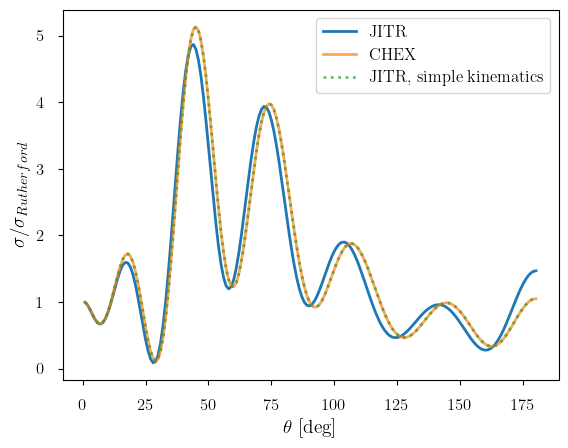

In [19]:
plt.plot(angles * 180 / np.pi, dxs, label="JITR")
plt.plot(
    xsp["theta"],
    xsp["dxs"],
    label="CHEX",
    alpha=0.7,
)
plt.plot(angles * 180 / np.pi, dxs_kip, ":", alpha=0.7, label="JITR, simple kinematics")

plt.xlabel(r"$\theta$ [deg]")
plt.ylabel(r" $\sigma / \sigma_{Rutherford}$")
plt.legend()

In [20]:
# %%timeit
# now for the neutron case
dxs = solvers[n].exact_dsdo(params[n][1])

In [21]:
# use same kinematics as chex
interactions_chex_match_kin = rose.InteractionSpace(
    coordinate_space_potential=rose.koning_delaroche.KD_simple,
    n_theta=rose.koning_delaroche.NUM_PARAMS,
    mu=912.48391836734697,
    energy=E_com_n,
    is_complex=True,
    spin_orbit_term=rose.koning_delaroche.KD_simple_so,
    Z_1=0,
    Z_2=Sc48[1],
    l_max=50,
)
solver_chex_match_kin = rose.ScatteringAmplitudeEmulator.HIFI_solver(
    interactions_chex_match_kin,
    base_solver=rose.LagrangeRmatrix(
        interactions_chex_match_kin.interactions[0][0],
        s_0_n,
        solver,
    ),
    angles=angles,
    s_mesh=s_mesh_n,
)
dxs_kin = solver_chex_match_kin.exact_dsdo(params[n][1])

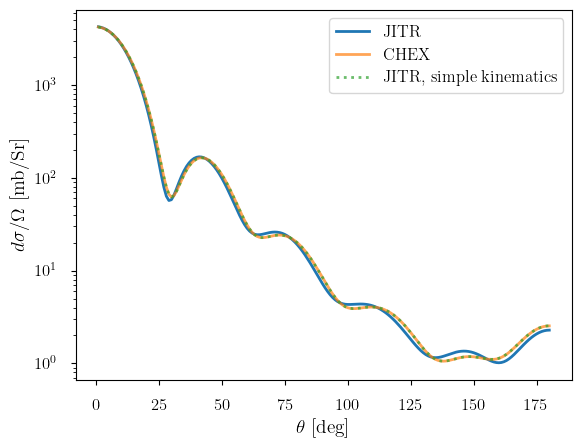

In [22]:
plt.semilogy(angles * 180 / np.pi, dxs, label="JITR")

plt.semilogy(xsn["theta"], xsn["dxs"], label="CHEX", alpha=0.7)
plt.semilogy(
    angles * 180 / np.pi, dxs_kin, ":", label="JITR, simple kinematics", alpha=0.7
)

plt.xlabel(r"$\theta$ [deg]")
plt.ylabel(r" $d \sigma / \Omega$ [mb/Sr]")
plt.legend()

### Compare wavefunctions between CHEX and JITR
We can see now that `JITR` is able to reproduce the differential elastic cross sections of `CHEX`, which means, asymptotically, the wavefunctions are the same up to an overall phase and normalization. For DWBA, we actually need to enforce a single, specific phase and normalization, namely

\begin{equation}
    u_l(r) \rightarrow \frac{i}{2} \left[ H_l^-(kr) - S_{jl} H^+_l(kr)  \right].
\end{equation}

This common convention is adopted by Thompson & Nunes, 2009, and is utilized in `CHEX` for the DWBA calculation.

#### read in CHEX wavefunctions for incoming and outgoing partial wave

In [23]:
# read in CHEX proton partial waves
from io import StringIO


def get_partial_wave(csv):
    return [float(x) for x in csv[0 : csv.find("\n")].strip().split()]


with open(
    "./chex_benchmark_results/CEResults/InNucleonScatWFs.txt", "r"
) as uin_file:
    wfp = [
        (
            get_partial_wave(csv),
            pd.read_csv(
                StringIO(csv[csv.find("\n") :].split("&")[0]),
                sep="\s+",
                header=None,
                names=["r", "real", "imag"],
            ),
        )
        for csv in uin_file.read().split("#")[1:]
    ]

In [24]:
# read in CHEX neutron partial waves
from io import StringIO


def get_partial_wave(csv):
    return [float(x) for x in csv[0 : csv.find("\n")].strip().split()]


with open(
    "./chex_benchmark_results/CEResults/OutNucleonScatWFs.txt", "r"
) as uin_file:
    wfn = [
        (
            get_partial_wave(csv),
            pd.read_csv(
                StringIO(csv[csv.find("\n") :].split("&")[0]),
                sep="\s+",
                header=None,
                names=["r", "real", "imag"],
            ),
        )
        for csv in uin_file.read().split("#")[1:]
    ]

In [25]:
from mpmath import coulombf, coulombg

l=0, j=0.5


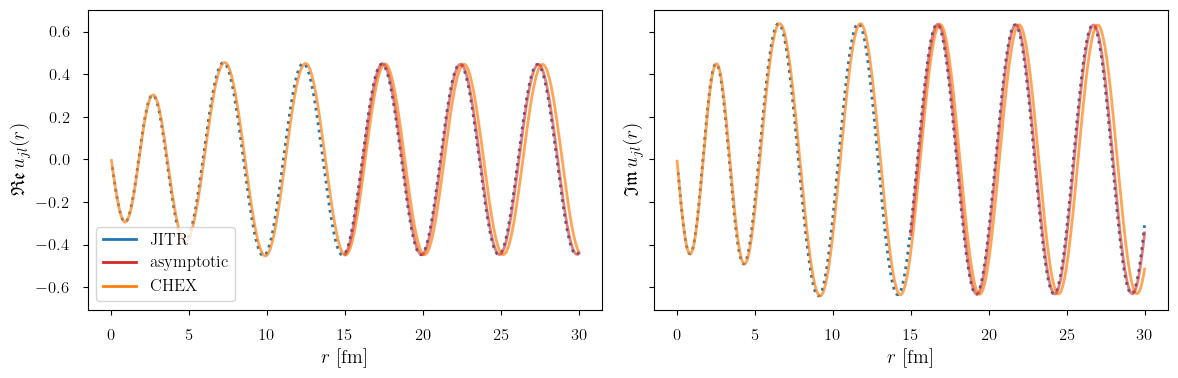

In [26]:
idx = 0
idx_l = (idx + 1) // 2
idx_j = (idx + 1) % 2 if idx > 0 else 0
(l, j) = wfp[idx][0]
print(f"l={int(l)}, j={j}")

r = wfp[idx][1]["r"].to_numpy(dtype=float)
i_asym = np.argmin(np.fabs(r - 15.0))

F = np.array([coulombf(l, eta_p, s * k_p) for s in r[i_asym:]], dtype=np.complex128)
G = np.array([coulombg(l, eta_p, s * k_p) for s in r[i_asym:]], dtype=np.complex128)
Hp = G + 1j * F
Hm = G - 1j * F

Sl = solvers_kip.exact_smatrix_elements(params[p][1])[idx_j][idx_l]
u_asymptotic = 1j / 2 * (Hm - Sl * Hp)
u_chex = wfp[idx][1]["real"].to_numpy() + 1j * wfp[idx][1]["imag"].to_numpy()

# get JITR wavefunction
r_jitr = solvers_kip.rbes[idx_l][idx_j].s_mesh / k_p
u_jitr_in = solvers_kip.exact_wave_functions(params[p][1])
u_jitr = np.interp(r, r_jitr, u_jitr_in[idx_l][idx_j])

# i_max = -10
# u_jitr *= np.mean(u_asymptotic[-10:] / u_jitr[-10:])

fig, (a1, a2) = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
a1.plot(r, u_jitr.real, ":", color="#1f77b4")
a2.plot(r, u_jitr.imag, ":", color="#1f77b4")

a1.plot(r, u_chex.real, "-", color="#ff7f0e", alpha=0.7)
a2.plot(r, u_chex.imag, "-", color="#ff7f0e", alpha=0.7)

a1.plot(r[i_asym:], u_asymptotic.real, "-", color="#d62728", alpha=0.6)
a2.plot(r[i_asym:], u_asymptotic.imag, "-", color="#d62728", alpha=0.6)

a1.legend(
    handles=[
        Line2D([], [], color="#1f77b4", label="JITR"),
        Line2D([], [], color="#d62728", label="asymptotic"),
        Line2D([], [], color="#ff7f0e", label="CHEX"),
    ]
)

a1.set_ylabel(r"$\mathfrak{Re} \, u_{jl}(r)$")
a2.set_ylabel(r"$\mathfrak{Im} \, u_{jl}(r)$")
a1.set_xlabel(r"$r$ [fm]")
a2.set_xlabel(r"$r$ [fm]")
plt.tight_layout()

l=0, j=0.5


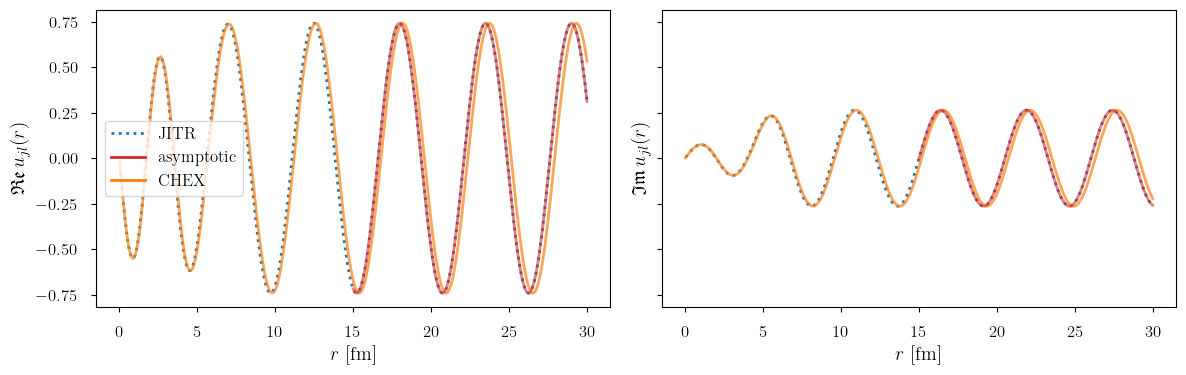

In [27]:
idx = 0
idx_l = (idx + 1) // 2
idx_j = (idx + 1) % 2 if idx > 0 else 0
(l, j) = wfn[idx][0]
print(f"l={int(l)}, j={j}")
# print(idx_l, idx_j)

r = wfn[idx][1]["r"].to_numpy(dtype=float)
i_asym = np.argmin(np.fabs(r - 15.0))

F = np.array([coulombf(l, 0, s * k_n) for s in r[i_asym:]], dtype=np.complex128)
G = np.array([coulombg(l, 0, s * k_n) for s in r[i_asym:]], dtype=np.complex128)
Hp = G + 1j * F
Hm = G - 1j * F

Sl = solver_chex_match_kin.exact_smatrix_elements(params[n][1])[idx_j][idx_l]
u_asymptotic = 1j / 2 * (Hm - Sl * Hp)
u_chex = wfn[idx][1]["real"].to_numpy() + 1j * wfn[idx][1]["imag"].to_numpy()

# get JITR wavefunction
r_jitr = solver_chex_match_kin.rbes[idx_l][idx_j].s_mesh / k_n
u_jitr_in = solver_chex_match_kin.exact_wave_functions(params[n][1])
u_jitr = np.interp(r, r_jitr, u_jitr_in[idx_l][idx_j])

fig, (a1, a2) = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
a1.plot(r, u_jitr.real, ":", color="#1f77b4")
a2.plot(r, u_jitr.imag, ":", color="#1f77b4")

a1.plot(r, u_chex.real, "-", color="#ff7f0e", alpha=0.7)
a2.plot(r, u_chex.imag, "-", color="#ff7f0e", alpha=0.7)

a1.plot(r[i_asym:], u_asymptotic.real, "-", color="#d62728", alpha=0.6)
a2.plot(r[i_asym:], u_asymptotic.imag, "-", color="#d62728", alpha=0.6)

a1.legend(
    handles=[
        Line2D([], [], color="#1f77b4", linestyle=":", label="JITR"),
        Line2D([], [], color="#d62728", label="asymptotic"),
        Line2D([], [], color="#ff7f0e", label="CHEX"),
    ]
)

a1.set_ylabel(r"$\mathfrak{Re} \, u_{jl}(r)$")
a2.set_ylabel(r"$\mathfrak{Im} \, u_{jl}(r)$")
a1.set_xlabel(r"$r$ [fm]")
a2.set_xlabel(r"$r$ [fm]")
plt.tight_layout()

Now that we can be sure we have the correct boundary conditions and normalization, we can compare DWBA T-matrix elements:

\begin{equation}
    \mathcal{T}^{DWBA}_{jl} = \langle \chi^+_{jl} \left| V_1 \right| \chi^-_{jl} \rangle
\end{equation}

In [28]:
def partial_wave_v1(alpha_n, alpha_p, solver_n, solver_p, r, A, Z):
    N = A - Z
    vn = solver_n.interaction.v_r(
        r, alpha_n
    ) + solver_n.interaction.spin_orbit_term.spin_orbit_potential(r, alpha_n)
    vp = solver_p.interaction.v_r(
        r, alpha_p
    ) + solver_p.interaction.spin_orbit_term.spin_orbit_potential(r, alpha_p)
    v1 = -(vn - vp) * np.sqrt(np.fabs(N - Z)) / (N - Z - 1)
    return v1


def solve_partial_wave_channel(alpha, solver):
    ch, im = solver.get_channel_info(alpha)
    _, Slj, xlj, uext_prime_boundary = solver.solver.solve(
        im,
        ch,
        free_matrix=solver.free_matrix,
        basis_boundary=solver.basis_boundary,
        wavefunction=True,
    )
    wvfxn = jitr.Wavefunctions(
        solver.solver,
        xlj,
        Slj,
        uext_prime_boundary,
        ch["weight"],
        jitr.make_channel_data(ch),
    )

    return Slj, wvfxn.uint()[0], ch["k"][0]


def partial_wave_dwba_pn(alpha_n, alpha_p, solver_n, solver_p, r, A, Z):
    v1 = partial_wave_v1(alpha_n, alpha_p, solver_n, solver_p, r, A, Z)
    Sn, wfxn_n, k_n = solve_partial_wave_channel(alpha_n, solver_n)
    Sp, wfxn_p, k_p = solve_partial_wave_channel(alpha_p, solver_p)

    wfxn_n = wfxn_n(r * k_n)
    wfxn_p = wfxn_p(r * k_p)

    # calculate DWBA (p,n) T-matrix
    Tpn = np.trapz(wfxn_n.conj() * v1 * wfxn_p, x=r)
    return Tpn, Sn, Sp, wfxn_n, wfxn_p


def dwba_pn(alpha_n, alpha_p, k_n, k_p, r, solvers):
    A, Z = Ca48
    N = A - Z
    l_max = min(solvers[n].l_max, solvers[p].l_max)

    Tnp = np.zeros((2, l_max), dtype=np.complex128)
    Sn = np.zeros((2, l_max), dtype=np.complex128)
    Sp = np.zeros((2, l_max), dtype=np.complex128)

    xn = np.zeros((2, l_max, r.size), dtype=np.complex128)
    xp = np.zeros((2, l_max, r.size), dtype=np.complex128)

    for li in range(solvers[n].l_max):
        for ji in range(2 if li > 0 else 1):
            solver_n = solvers[n].rbes[li][ji].basis.solver
            solver_p = solvers[p].rbes[li][ji].basis.solver

            Tpnlj, Snlj, Splj, xnlj, xplj = partial_wave_dwba_pn(
                alpha_n,
                alpha_p,
                solver_n,
                solver_p,
                r,
                N,
                Z,
            )
            Tnp[ji, li] = Tpnlj
            Sn[ji, li] = Snlj
            Sp[ji, li] = Splj
            xn[ji, li, :] = xnlj
            xp[ji, li, :] = xplj

    return Tnp, Sp, Sn, xp, xn

Let's step through these functions one by one, comparing the $\ell,j = 0,1/2$ partial wave to CHEX. Let's begin with the potential matrix element:

In [29]:
r = np.linspace(0.001, a, 1000)

In [30]:
v1 = partial_wave_v1(
    params[n][1],
    params[p][1],
    solver_chex_match_kin.rbes[0][0].basis.solver,
    solvers_kip.rbes[0][0].basis.solver,
    r,
    *Ca48,
)

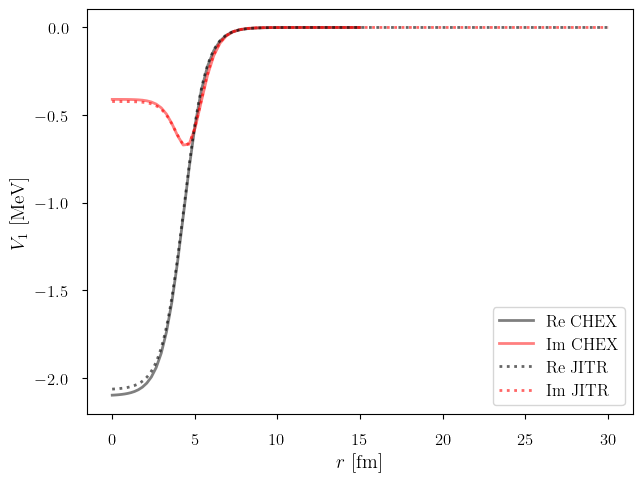

In [31]:
plt.plot(chex_v1["r"], chex_v1["V"], "k", label="Re CHEX", alpha=0.5)
plt.plot(chex_v1["r"], chex_v1["W"], "r", label="Im CHEX", alpha=0.5)
plt.plot(r, v1.real, "k:", alpha=0.6, label="Re JITR")
plt.plot(r, v1.imag, "r:", alpha=0.6, label="Im JITR")

plt.legend()
plt.tight_layout()
plt.xlabel(r"$r$ [fm]")
plt.ylabel(r"$V_1$ [MeV]")
plt.show()

Good, now let's look at the DWBA partial waves:

In [32]:
Sn, wvn, kn = solve_partial_wave_channel(
    params[n][1],
    solver_chex_match_kin.rbes[0][0].basis.solver,
)
Sp, wvp, kp = solve_partial_wave_channel(
    params[p][1],
    solvers_kip.rbes[0][0].basis.solver,
)

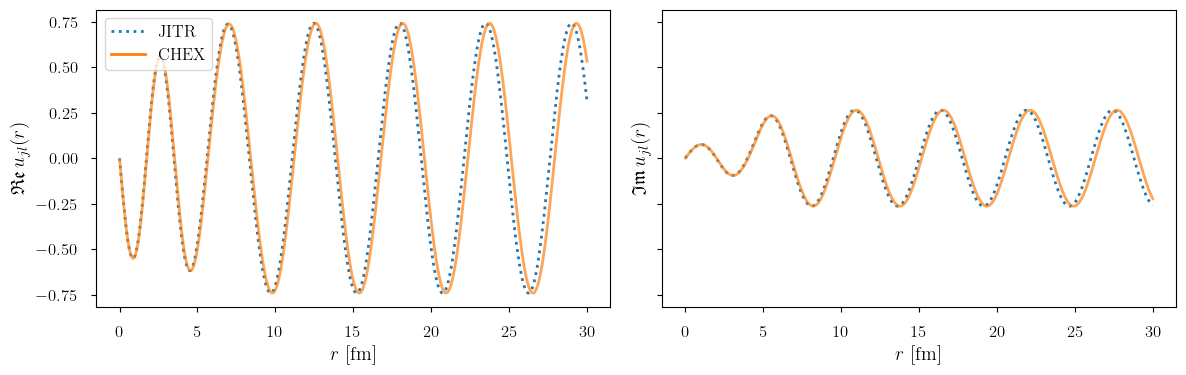

In [33]:
fig, (a1, a2) = plt.subplots(1, 2, sharey=True, figsize=(12, 4))

a1.plot(r, wvn(r * k_n).real, ":", color="#1f77b4")
a2.plot(r, wvn(r * k_n).imag, ":", color="#1f77b4")

rchex = wfn[0][1]["r"].to_numpy(dtype=float)
u_chex = wfn[0][1]["real"].to_numpy() + 1j * wfn[0][1]["imag"].to_numpy()

a1.plot(rchex, u_chex.real, "-", color="#ff7f0e", alpha=0.7)
a2.plot(rchex, u_chex.imag, "-", color="#ff7f0e", alpha=0.7)

a1.legend(
    handles=[
        Line2D([], [], color="#1f77b4", linestyle=":", label="JITR"),
        Line2D([], [], color="#ff7f0e", label="CHEX"),
    ]
)

a1.set_ylabel(r"$\mathfrak{Re} \, u_{jl}(r)$")
a2.set_ylabel(r"$\mathfrak{Im} \, u_{jl}(r)$")
a1.set_xlabel(r"$r$ [fm]")
a2.set_xlabel(r"$r$ [fm]")
plt.tight_layout()

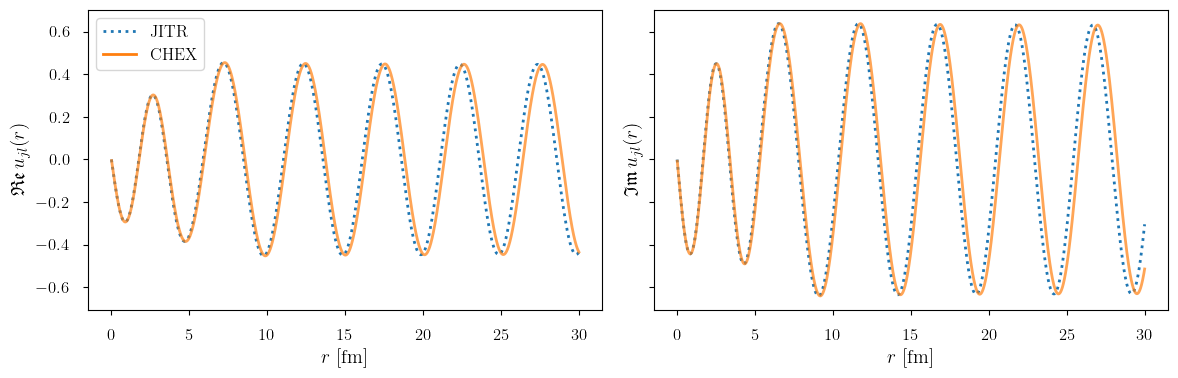

In [34]:
fig, (a1, a2) = plt.subplots(1, 2, sharey=True, figsize=(12, 4))

a1.plot(r, wvp(r * k_p).real, ":", color="#1f77b4")
a2.plot(r, wvp(r * k_p).imag, ":", color="#1f77b4")

rchex = wfp[0][1]["r"].to_numpy(dtype=float)
u_chex = wfp[0][1]["real"].to_numpy() + 1j * wfp[0][1]["imag"].to_numpy()

a1.plot(rchex, u_chex.real, "-", color="#ff7f0e", alpha=0.7)
a2.plot(rchex, u_chex.imag, "-", color="#ff7f0e", alpha=0.7)

a1.legend(
    handles=[
        Line2D([], [], color="#1f77b4", linestyle=":", label="JITR"),
        Line2D([], [], color="#ff7f0e", label="CHEX"),
    ]
)

a1.set_ylabel(r"$\mathfrak{Re} \, u_{jl}(r)$")
a2.set_ylabel(r"$\mathfrak{Im} \, u_{jl}(r)$")
a1.set_xlabel(r"$r$ [fm]")
a2.set_xlabel(r"$r$ [fm]")
plt.tight_layout()

Great, now let's compare the radial integral of the partial wave matrix element. The corresponding value generated by CHEX is $1.160, - i 0.797$:

In [35]:
np.trapz(wvn(r * k_n) * v1 * wvp(r * k_p), x=r)

(-0.5812989863509814-1.3582607607067552j)

Not bad, now let's do the integral in radial quadrature:

##### 

In [36]:
kernel = jitr.QuadratureKernel(40)
r = kernel.quadrature.abscissa * a
v1 = partial_wave_v1(
    params[n][1],
    params[p][1],
    solver_chex_match_kin.rbes[0][0].basis.solver,
    solvers_kip.rbes[0][0].basis.solver,
    r,
    *Ca48,
)
np.sum(wvn(r * k_n) * v1 * wvp(r * k_p) * kernel.quadrature.weights) * a

(-0.582122016245925-1.3586402453118531j)

## Calculation of the the differential cross section for quasi-elastic $(p,n)$

We can grab experimental quasi-elastic $(p,n)$ data from this [EXFOR entry](https://www-nds.iaea.org/exfor/servlet/X4sGetSubent?reqx=15435&subID=141667014&plus=1). Let's compare it to the CHEX prediction.

In [37]:
ca48_pn_ias = np.array(
    [
        [0.0000, 0.70000, 0.035000],
        [3.0700, 0.61300, 0.047000],
        [10.240, 0.68200, 0.050000],
        [15.360, 1.1800, 0.061000],
        [20.480, 2.5452, 0.073000],
        [25.590, 3.4110, 0.090000],
        [30.700, 2.9580, 0.084000],
        [35.800, 1.7724, 0.063000],
        [40.900, 1.1964, 0.053000],
        [51.070, 1.0356, 0.040000],
        [61.210, 1.0536, 0.035000],
        [81.380, 0.23300, 0.020000],
        [91.400, 0.22600, 0.017000],
        [101.37, 0.15000, 0.016000],
        [111.31, 0.064000, 0.0100000],
        [121.21, 0.094000, 0.012000],
        [131.07, 0.053000, 0.011000],
    ]
)

In [38]:
ca48_pn_ias[:,0]

array([  0.  ,   3.07,  10.24,  15.36,  20.48,  25.59,  30.7 ,  35.8 ,
        40.9 ,  51.07,  61.21,  81.38,  91.4 , 101.37, 111.31, 121.21,
       131.07])

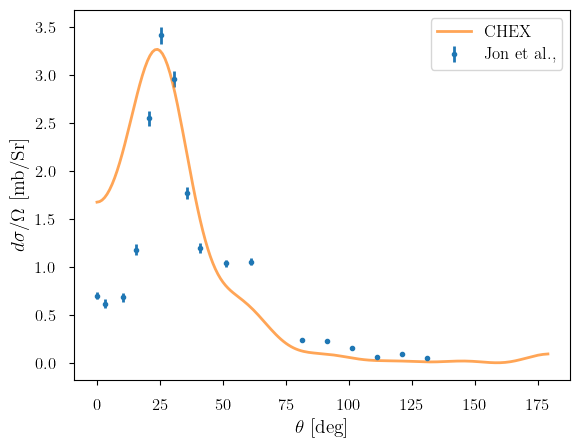

In [39]:
plt.errorbar(ca48_pn_ias[:,0], ca48_pn_ias[:,1], yerr=ca48_pn_ias[:,2], label="Jon et al., ", linestyle="none", marker='.')

plt.plot(xspn["theta"], xspn["dxs"], label="CHEX", alpha=0.7)
plt.xlabel(r"$\theta$ [deg]")
plt.ylabel(r" $d \sigma / \Omega$ [mb/Sr]")
plt.legend()

Cool, this looks right. Now let's recreate it with JITR.

In [40]:
Tnp, Sp, Sn, xp, xn = dwba_pn(params[n][1], params[p][1], k_n, k_p, r, solvers)

/tmp/ipykernel_1328226/1193347012.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Sn[ji, li] = Snlj
/tmp/ipykernel_1328226/1193347012.py:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Sp[ji, li] = Splj


In [58]:
from sympy.physics.wigner import clebsch_gordan
from scipy.special import eval_legendre, gamma

l_max = 20
T = np.zeros((2,2,l_max,2), dtype=np.complex128)
SCG = np.zeros((2,2,l_max,2), dtype=np.complex128)
ls = np.arange(l_max)
sigma_c = np.angle(gamma(1 + ls + 1j * eta_p))
for im, mu in enumerate([-0.5,0.5]):
    for imp, mu_pr in enumerate([-0.5,0.5]):
        for l in range(0,l_max):
            for ijp, jp in enumerate([l - 0.5, l+0.5]):
                if abs(mu - mu_pr) <= l and jp >= 0:
                    cg0 = clebsch_gordan(l, 1/2, jp,  mu - mu_pr, mu, mu_pr)
                    cg1 = clebsch_gordan(l, 1/2, jp, 0, mu, mu)
                    SCG[im,imp,l,ijp] = (4 * np.pi)**(3./2.) / (k_p * k_n) * np.exp( 1j * sigma_c[l] ) * cg1 * cg0 * np.sqrt(2 * l + 1)